In [ ]:
!pip install opencv-python
!pip install numpy, matplotlib

ERROR: Invalid requirement: 'numpy,'


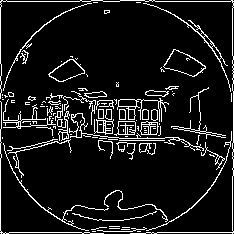

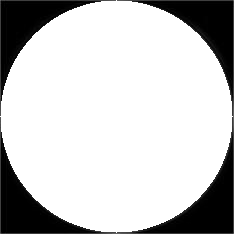

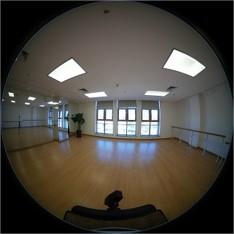

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# 1. 导入图片P并获取边缘图E
img = cv2.imread('/content/image.jpg')
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray_img, threshold1=30, threshold2=100)
cv2_imshow(edges)

# 2. 在边缘图E中寻找最大圆
circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, dp=1, minDist=20,
                           param1=50, param2=30, minRadius=0, maxRadius=0)

if circles is not None:
    circles = np.uint16(np.around(circles))
    max_circle = circles[0, 0]  # Assuming there is only one circle
    center_x, center_y, radius = max_circle[0], max_circle[1], max_circle[2]

    # 3. 可视化最大圆
    img_circle = gray_img.copy()
    cv2.circle(img_circle, (center_x, center_y), radius, 255, -1)  # Draw the circle on original image

    # 4. 显示结果
    cv2_imshow(img_circle)
    cv2_imshow(img)

else:
    print("No circle detected in the image.")


In [ ]:
print(radius)

116


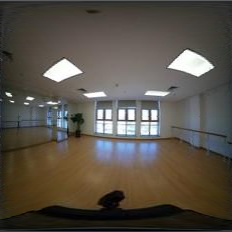

In [ ]:
# 3. 对圆内的像素沿x轴遍历，统计每一行的像素数量n
inner_circle_rows = []
for y in range(center_y - radius, center_y + radius):
    row_pixels = np.sum(img_circle[y, center_x - radius:center_x + radius] > 240)
    inner_circle_rows.append(row_pixels)

# 4. 构建空白图像
max_row_pixels = max(inner_circle_rows)
blank_image_height = 2 * radius  # You can adjust this as needed
blank_image_width = max_row_pixels
blank_image = np.zeros((blank_image_height, blank_image_width, 3), dtype=np.uint8)

# 5. 将圆内每行像素拉伸至长度R并进行插值填充
for i, pixels in enumerate(inner_circle_rows):
    for k in range(3):
      scaled_row = cv2.resize(img[center_y - radius + i, center_x - pixels//2:center_x + pixels//2+1, k],
                              (1, max_row_pixels), interpolation=cv2.INTER_LINEAR)
      blank_image[i, :, k] = scaled_row.flatten()

cv2_imshow(blank_image)

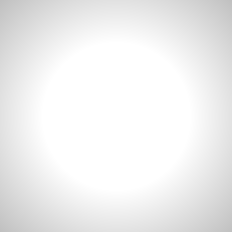

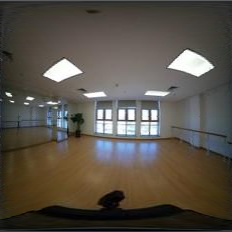

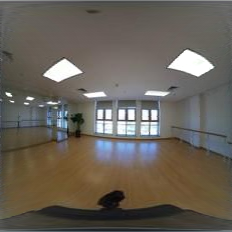

In [ ]:
def create_vignette(image, strength=0.5, protect=0):
    # 创建一个与图像大小相同的遮罩
    mask = np.zeros_like(image)

    # 计算图像中心点坐标
    center_x = image.shape[1] // 2
    center_y = image.shape[0] // 2

    # 计算遮罩的半径
    max_distance = np.sqrt((center_x ** 2) + (center_y ** 2))

    # 应用暗角效果到遮罩
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            distance = np.sqrt(((x - center_x) ** 2) + ((y - center_y) ** 2))
            # 根据距离计算暗角强度
            vignette_strength = min(1 - (distance / max_distance) * strength + protect, 1)
            mask[y, x] = np.ones((1,3), dtype=np.uint8) * (255 - vignette_strength * 255)

    return mask

# 应用暗角效果到方形图像
vignette_strength = 0.45  # 暗角强度，可以调整
vignette_protect = 0.2  # 保护距离


# for i in range(10):
#     vignette_strength = 0.1 * i
#     mask = create_vignette(gray_img, vignette_strength, vignette_protect)
#     cv2_imshow(mask)

mask = create_vignette(blank_image, vignette_strength, vignette_protect)
cv2_imshow(255-mask)

# before adding mask
cv2_imshow(blank_image)

# add mask
result = cv2.add(blank_image, mask)

cv2_imshow(result)
